# AIDE-MÉMOIRE RAPIDE (CTRL+F)

## 1. Unités & Variables Clés
*   **Force ($F$)** : Newton [N] ($1 \text{ N} = 1 \text{ kg} \cdot \text{m/s}^2$).
*   **Pression ($p$)** : Pascal [Pa] ($1 \text{ bar} = 10^5 \text{ Pa}$).
*   **Contrainte ($\sigma$, Stress)** : Force par surface ($F/S$), en [Pa] ou [N/m²].
*   **Déformation ($\epsilon$, Strain)** : Allongement relatif ($\Delta L / L$), sans unité (souvent en $\mu\epsilon$ ou $\mu\text{m/m}$).
*   **Facteur de Jauge ($K$)** : Sensibilité d'une jauge de contrainte ($\Delta R/R = K \cdot \epsilon$).
*   **Module de Young ($E$)** : Rigidité du matériau (Acier $\approx 210$ GPa). Loi de Hooke : $\sigma = E \cdot \epsilon$.
*   **Sensibilité ($S$)** : Rapport Sortie/Entrée (ex: [V/bar], [C/N], [V/(m/s²)]).
*   **Charge ($Q$)** : Coulomb [C] (Pour les capteurs piézo).

## 2. Formules Rapides
*   **Erreur Absolue** : $E = \text{Mesure} - \text{Vraie}$.
*   **Erreur Relative** : $\epsilon = E / \text{Vraie}$.
*   **Précision Multimètre** : $\pm(\% \text{Lecture} + \% \text{Gamme} + \text{Digits})$.
*   **Résolution Numérique** : $\Delta V = \text{Plage} / 2^N$.
*   **Puissance AC** : $P_{active} = U_{eff} \cdot I_{eff} \cdot \cos \phi$.
*   **Décibels (dB)** : $G_{dB} = 20 \log_{10}(U_{out}/U_{in})$ ou $10 \log_{10}(P_{out}/P_{in})$.

## 3. Capteurs Spécifiques
*   **Jauges (Pont de Wheatstone)** :
    *   *Quart de pont* : $U_m \approx \frac{U_0}{4} K \epsilon$
    *   *Demi pont* : $U_m \approx \frac{U_0}{2} K \epsilon$
    *   *Pont complet* : $U_m \approx U_0 K \epsilon$ (Dépend du montage Poisson)
*   **Piézoélectrique** :
    *   $Q = \beta \cdot F$
    *   $U = Q / C_{tot}$ avec $C_{tot} = C_{capteur} + C_{cable} + C_{ampli}$
*   **RTD (Pt100)** : $R(T) \approx R_0(1 + \alpha T)$

# Copy, paste, and calculate
**Common Questions**: list of validated snippets

In [243]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sympy as sp

# Configuration pour affichage propre
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:,.4f}'.format
plt.style.use('default')
print("Librairies chargées")

Librairies chargées


## Rapport Crête / Efficace
**Question :** Quel est le rapport entre la valeur de crête ($\hat{u}$) et la valeur efficace ($U_{eff}$) d'un signal triangulaire redressé ?

**Théorie :**
*   Le redressement (valeur absolue) ne change pas l'énergie, donc la valeur efficace (RMS) d'un signal triangulaire redressé est la même que celle d'un triangulaire standard.
*   **Formule RMS (Triangle/Dent de scie) :** $U_{eff} = \frac{U_{crête}}{\sqrt{3}}$
*   **Rapport Théorique :** $\frac{U_{crête}}{U_{eff}} = \sqrt{3} \approx 1.732$

In [278]:
t,T,X_pk=sp.symbols("t,T,X_pk", positive=True)
# the triangle is symetric in time, the RMS of the rising part and the falling parts is the s# we define a function for the first part only, and compute the RMS for that part.
v = (t / T) * X_pk

# Use 2 * pi * t / T to ensure integration covers exactly one full cycle
# v = X_pk * sp.sin(2 * sp.pi * (t / T))

RMS=sp.sqrt(sp.integrate(v**2,(t,0,T))/T)
RMS.simplify()



√3⋅Xₚₖ
──────
  3   

## Potentiomètre Linéaire en Charge
**Énoncé:**
Un potentiomètre de $R_{pot} = 10\text{k}\Omega$ est alimenté par $V_0 = 3.3\text{V}$.
Le curseur est chargé par une résistance $R_L = 5\text{k}\Omega$.
On cherche la tension $U_{out}$ pour les positions du curseur : 0%, 50%, 75%, 100%.

**Théorie:**
Le potentiomètre est divisé en deux résistances par la position du curseur $x$ (de 0 à 1) :
*   $R_{haut} = (1 - a) \cdot R_{pot}$
*   $R_{bas} = a \cdot R_{pot}$

La résistance de charge $R_L$ est en parallèle avec la partie basse $R_{bas}$.
1.  Calculer la résistance équivalente basse : $R_{eq} = R_{bas} // R_L = \frac{R_{bas} \cdot R_L}{R_{bas} + R_L}$
2.  Calculer la tension de sortie (Diviseur de tension) : $U_{out} = V_0 \cdot \frac{R_{eq}}{R_{haut} + R_{eq}}$

<div align="center">
    <img src="Fig/Pot-Charge_Lin.png" width="500px">
    <p><b>Figure 1:</b> Schéma du montage du potentiomètre avec charge RL.</p>
</div>

In [273]:
# --- VALEURS D'ENTRÉE ---
V1 = 3.3            # Tension d'alimentation [V]
R_pot = 10000.0     # Résistance totale du potentiomètre [Ohm]
R_load = 5000.0     # Résistance de charge RL [Ohm]
Pos_mes = 49        # Position du Pot 0-99

# FIX: Créer une plage de 0 à 100% pour voir la courbe
positions_pct = np.linspace(0, 100, 50)

# Listes pour stocker les résultats du graphique
x_plot = []
y_plot = []

# --- CALCUL ---
for pos in positions_pct:
    x = pos / 100.0

    # 1. Résistances du potentiomètre
    R_bas = x * R_pot
    R_haut = (1 - x) * R_pot

    # 2. Résistance équivalente (R_bas // R_load)
    if (R_bas + R_load) == 0:
        R_eq = 0
    else:
        R_eq = (R_bas * R_load) / (R_bas + R_load)

    # 3. Diviseur de tension
    if (R_haut + R_eq) == 0:
        U_out = 0
    else:
        U_out = V1 * (R_eq / (R_haut + R_eq))

    x_plot.append(pos)
    y_plot.append(U_out)

print(f"Tension V de sortie a position {Pos_mes+1:.2f} %: {y_plot[ int(Pos_mes/2)]:.2f} V")


Tension V de sortie a position 50.00 %: 1.08 V


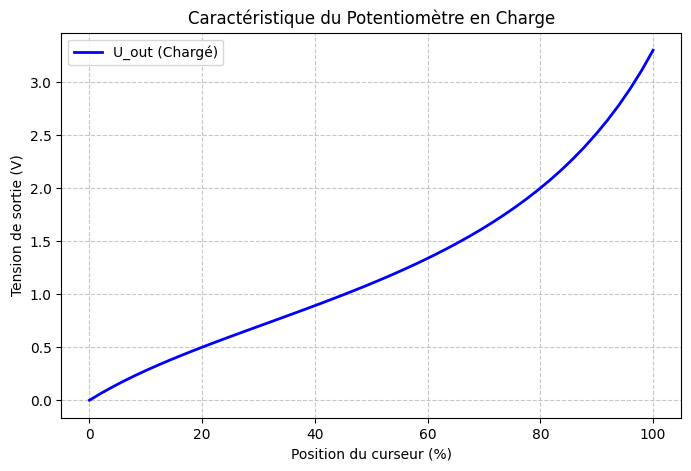

In [264]:
# --- GRAPHIQUE ---
plt.figure(figsize=(8, 5))
plt.style.use('default') # Force le fond blanc

plt.plot(x_plot, y_plot, color='blue', linewidth=2, label='U_out (Chargé)')

# AJOUT DES LABELS ET DE LA GRILLE (Avant plt.show)
plt.title("Caractéristique du Potentiomètre en Charge")
plt.xlabel("Position du curseur (%)")
plt.ylabel("Tension de sortie (V)")
plt.grid(True, linestyle='--', alpha=0.7) # Crée la grille en pointillés
plt.legend()

plt.show()

## Pont de Wheatstone (Résistances)
**Quand l'utiliser ?**
Lorsque l'examen donne 4 valeurs de résistance ($R_1, R_2, R_3, R_4$) et demande la tension de sortie $U_m$ (ou $V_{out}$).

**Formules :**
*   **Diviseur de tension :** $V_{gauche} = U_0 \frac{R_2}{R_1 + R_2}$ et $V_{droite} = U_0 \frac{R_4}{R_3 + R_4}$
*   **Tension de mesure :** $U_m = V_{gauche} - V_{droite}$
*   **Condition d'équilibre :** $R_1 \cdot R_4 = R_2 \cdot R_3$ (si vrai, $U_m = 0$)

**Schéma supposé :**
*   Branche Gauche : $R_1$ (Haut), $R_2$ (Bas)
*   Branche Droite : $R_3$ (Haut), $R_4$ (Bas)

In [246]:
# --- VALEURS D'ENTRÉE ---
U0 = 10.0      # Tension d'alimentation [V]
R1 = 120.0     # Résistance Haut-Gauche [Ohm]
R2 = 120.1     # Résistance Bas-Gauche  [Ohm]
R3 = 120.0     # Résistance Haut-Droite [Ohm]
R4 = 119.9     # Résistance Bas-Droite  [Ohm]

# --- CALCUL ---
V_gauche = U0 * (R2 / (R1 + R2))
V_droite = U0 * (R4 / (R3 + R4))
Um = V_gauche - V_droite
R_eq = (R1 * R4) - (R2 * R3)

print(f"--- RÉSULTATS PONT ÉLECTRIQUE ---")
print(f"Tension V_gauche : {V_gauche:.6f} V")
print(f"Tension V_droite : {V_droite:.6f} V")
print(f"Output => Tension de sortie Um : {Um:.6f} V ({Um*1000:.3f} mV)")

if abs(R_eq) < 1e-5:
    print("Le pont est ÉQUILIBRÉ.")
else:
    print(f"Le pont est DÉSÉQUILIBRÉ (Déséquilibre R: {R_eq:.4f})")

--- RÉSULTATS PONT ÉLECTRIQUE ---
Tension V_gauche : 5.002082 V
Tension V_droite : 4.997916 V
Output => Tension de sortie Um : 0.004167 V (4.167 mV)
Le pont est DÉSÉQUILIBRÉ (Déséquilibre R: -24.0000)


## Jauges de Contrainte (Strain Gauges)
**Quand l'utiliser ?**
Pour calculer la tension de sortie d'un pont ($U_m$) à partir d'une force ($F$), d'une pression ou d'une déformation ($\epsilon$).

**Formules :**
*   **Contrainte (Stress) :** $\sigma = F / S$ [Pa]
*   **Déformation (Strain) :** $\epsilon = \sigma / E = \Delta L / L$
*   **Tensions de sortie ($U_m$) :**
    *   *Quart de pont (1 jauge)* : $U_m \approx \frac{U_0}{4} \cdot K \cdot \epsilon$
    *   *Demi pont (2 jauges)* : $U_m \approx \frac{U_0}{2} \cdot K \cdot \epsilon$
    *   *Pont complet (4 jauges)* : $U_m \approx U_0 \cdot K \cdot \epsilon$ (Attention au facteur Poisson $\nu$)

In [247]:
# --- VALEURS D'ENTRÉE ---
U0 = 10.0           # Alimentation [V]
K = 2.0             # Facteur de jauge (Gauge Factor)
E_module = 210e9    # Module de Young [Pa] (Acier ~210e9, Alu ~70e9)
nu = 0.3            # Poisson (Acier ~0.3)

# Option A : On connait la déformation epsilon
epsilon = 1000e-6   # ex: 1000 µm/m (laisser None si on utilise la Force)

# Option B : On connait la Force (Calculera epsilon)
Force = None        # Force en [N] (mettre une valeur ex: 5000)
Section = 20e-4     # Surface en [m2] (ex: 20cm2 = 20e-4)

# Type de pont : 'quart', 'demi', 'complet_flexion', 'complet_poisson'
type_pont = 'complet_poisson'

# --- CALCUL ---
if Force is not None:
    sigma = Force / Section
    epsilon = sigma / E_module
    print(f"-> Contrainte calculée : {sigma/1e6:.2f} MPa")

Um = 0
config = ""

if type_pont == 'quart':
    # Source [1]: Um = U0/4 * K * eps
    Um = (U0 / 4) * K * epsilon
    config = "Quart de pont (1 Jauge)"

elif type_pont == 'demi':
    # Push-pull standard
    Um = (U0 / 2) * K * epsilon
    config = "Demi pont (2 Jauges)"

elif type_pont == 'complet_poisson':
    # Source [2]: Um = U0/2 * K * eps * (1 + nu) pour traction/compression
    # Note: Parfois simplifié sans le /2 selon le câblage exact, vérifier schéma source [2]
    Um = (U0 / 2) * K * epsilon * (1 + nu)
    config = f"Pont Complet (Poisson nu={nu})"

print(f"--- RÉSULTATS JAUGES ({config}) ---")
print(f"Déformation (ε) : {epsilon*1e6:.2f} µm/m")
print(f"Output => Tension Sortie Um : {Um:.6f} V ({Um*1000:.3f} mV)")

--- RÉSULTATS JAUGES (Pont Complet (Poisson nu=0.3)) ---
Déformation (ε) : 1000.00 µm/m
Output => Tension Sortie Um : 0.013000 V (13.000 mV)


## Capteur Piézoélectrique
**Quand l'utiliser ?**
Pour les accéléromètres ou capteurs de force piézo. Relie Charge ($Q$), Force ($F$) et Tension ($U$).

**Formules:**
*   **Force :** $F = M_s \cdot a$
*   **Charge :** $Q = \beta \cdot F$ (ou $d_{33} \cdot F$)
*   **Capacité Capteur :** $C_q = \frac{\epsilon_0 \epsilon_r S}{h}$
*   **Tension Sortie :** $U = \frac{Q}{C_{tot}}$ avec $C_{tot} = C_q + C_{cable} + C_{ampli}$
*   **Sensibilité :** $S = \frac{U}{a} = \frac{M_s \cdot \beta}{C_{tot}}$

In [248]:
# --- VALEURS D'ENTRÉE (Ex 7.2 Source [5]) ---
beta = 2.26e-12     # Sensibilité charge [C/N]
Ms_kg = 1e-3        # Masse sismique [kg] (1g = 0.001)
accel = 9.81        # Accélération [m/s^2] (1g)

# Capacités
C_cable = 2e-12     # Capacité parasite câble/ampli [F] (ex: 2pF)

# Géométrie Cristal (pour calculer C_interne)
D_mm = 3.0          # Diamètre [mm]
H_mm = 1.0          # Epaisseur [mm]
epsilon_r = 4.5     # Permittivité relative
epsilon_0 = 8.85e-12

# --- CALCUL ---
# 1. Capacité Interne
Surface = np.pi * ((D_mm/1000.0)/2)**2
C_sensor = (epsilon_0 * epsilon_r * Surface) / (H_mm/1000.0)
C_total = C_sensor + C_cable

# 2. Mécanique & Electrique
Force = Ms_kg * accel
Charge_Q = beta * Force
U_out = Charge_Q / C_total

# 3. Sensibilité globale
Sensibilite_S = (beta * Ms_kg) / C_total # [V / (m/s^2)]

print(f"--- RÉSULTATS PIÉZO ---")
print(f"Capacité Capteur : {C_sensor*1e12:.2f} pF")
print(f"Capacité Totale  : {C_total*1e12:.2f} pF")
print(f"Force Appliquée  : {Force:.4f} N")
print(f"Charge Générée   : {Charge_Q:.3e} C")
print(f"Output => Tension Sortie : {U_out:.6f} V")
print(f"Output => Sensibilité    : {Sensibilite_S:.6f} V/(m/s²)")

--- RÉSULTATS PIÉZO ---
Capacité Capteur : 0.28 pF
Capacité Totale  : 2.28 pF
Force Appliquée  : 0.0098 N
Charge Générée   : 2.217e-14 C
Output => Tension Sortie : 0.009718 V
Output => Sensibilité    : 0.000991 V/(m/s²)


## Erreurs & Précision (Multimètre)
**Quand l'utiliser ?**
Pour calculer l'erreur absolue et relative d'un appareil numérique.

**Formules:**
*   **Erreur Totale** = $\pm (\% \text{Lecture} \cdot \text{Valeur} + \% \text{Gamme} \cdot \text{Range} + \text{Digits} \cdot \text{Résolution})$
*   **Erreur Relative** = $\frac{\text{Erreur Totale}}{\text{Valeur Lue}} \cdot 100$

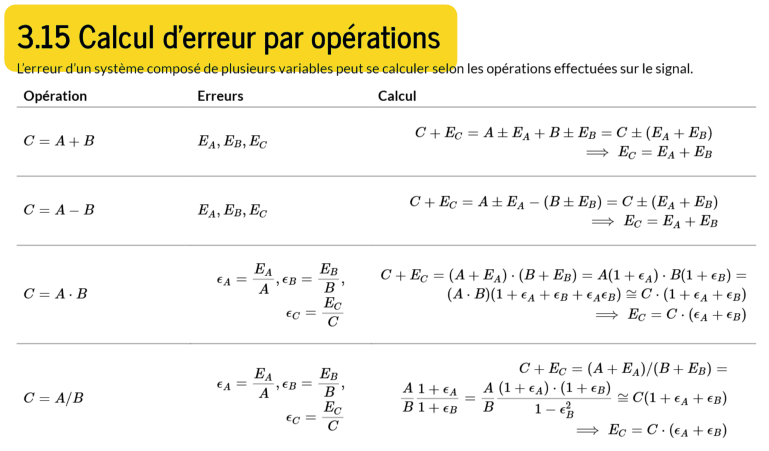
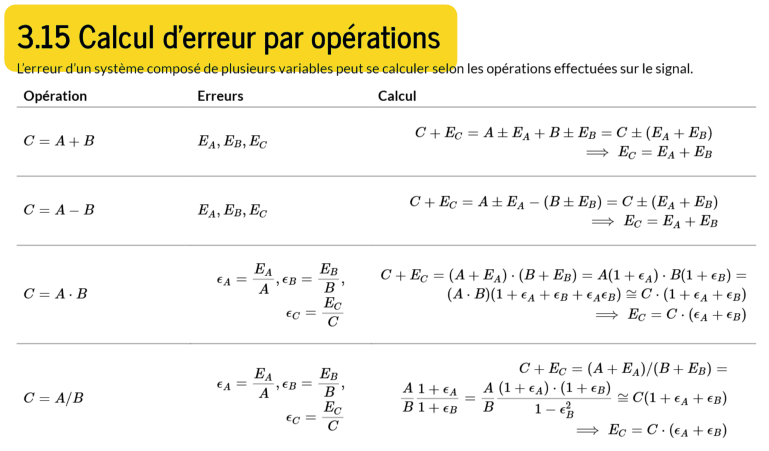

In [249]:
# --- VALEURS D'ENTRÉE ---
lecture = 150.0       # Valeur affichée
gamme = 200.0         # Gamme (Full Scale / Range)
prec_lecture = 1.5    # % de la lecture (Gain error)
prec_gamme = 0.5      # % de la gamme (Offset error) Précision
nb_digits = 2         # Nombre de digits (dgt)
resolution = 0.1      # Valeur d'un digit (ex: 0.1V pour gamme 200.0)

# --- CALCUL ---
err_prop = (prec_lecture / 100.0) * lecture
err_const = (prec_gamme / 100.0) * gamme
err_digit = nb_digits * resolution

erreur_totale = err_prop + err_const + err_digit
erreur_rel = (erreur_totale / lecture) * 100.0 if lecture != 0 else float('inf')

print(f"--- ANALYSE D'ERREUR ---")
print(f"Erreur proportionnelle : {err_prop:.4f}")
print(f"Erreur constante       : {err_const + err_digit:.4f}")
print(f"Output => Erreur Absolue      : +/- {erreur_totale:.4f}")
print(f"Output => Erreur Relative     : +/- {erreur_rel:.2f} %")
print(f"Plage vraie : [{lecture - erreur_totale:.4f} à {lecture + erreur_totale:.4f}]")

--- ANALYSE D'ERREUR ---
Erreur proportionnelle : 2.2500
Erreur constante       : 1.2000
Output => Erreur Absolue      : +/- 3.4500
Output => Erreur Relative     : +/- 2.30 %
Plage vraie : [146.5500 à 153.4500]


## Régression Linéaire (Calibration)
**Quand l'utiliser ?**
Pour trouver la sensibilité ($a$) et l'offset ($b$) d'un capteur à partir d'une série de points ($x_i, y_i$).

**Modèle:**
*   $y = a \cdot x + b$
*   $a$ = Pente (Sensibilité)
*   $b$ = Ordonnée à l'origine (Offset)
*   Erreur de linéarité = Écart max entre Modèle et Mesure.

In [250]:
# --- VALEURS D'ENTRÉE ---
# x = Mesurande (ex: Pression [bar])
x_vals = np.array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5])
# y = Sortie (ex: Tension [V])
y_vals = np.array([0.35, 0.67, 1.14, 1.84, 2.26, 2.8, 3.26, 3.58, 4.17, 4.68])

# --- CALCUL ---
# np.polyfit renvoie [pente, offset]
coeffs = np.polyfit(x_vals, y_vals, 1)

# EXTRACTION CORRECTE
a_pente = coeffs[0]
b_offset = coeffs[1]

# Calcul du modèle (maintenant a_pente est un simple nombre)
y_model = a_pente * x_vals + b_offset
erreurs = np.abs(y_vals - y_model)
max_err = np.max(erreurs)


print(f"--- CALIBRATION ---")
print(f"Output => Modèle : y = {a_pente:.4f} * x + ({b_offset:.4f})")
print(f"Sensibilité (a) : {a_pente:.4f}")
print(f"Offset (b)      : {b_offset:.4f}")
print(f"y(x)={a_pente:.3f} * x+ {b_offset:.3f}")
print(f"Erreur Max      : {max_err:.4f}")


Output => Modèle : y = 0.4877 * x + (0.0365)
Sensibilité (a) : 0.4877
Offset (b)      : 0.0365
y(x)=0.488 * x+ 0.037
Erreur Max      : 0.1158


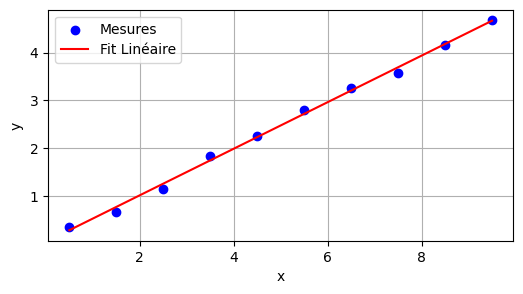

In [251]:
# Graphique
plt.figure(figsize=(6, 3))
plt.scatter(x_vals, y_vals, color='blue', label='Mesures')
plt.plot(x_vals, y_model, color='red', label='Fit Linéaire')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True); plt.legend(); plt.show()

## Analyse FFT (Spectre)
**Quand l'utiliser ?**
Pour convertir des indices de tableau FFT ($k$) en fréquences ($f$) ou trouver la résolution.

**Formules:**
*   **Résolution :** $\Delta f = \frac{f_s}{N}$
*   **Conversion :** $f = k \cdot \Delta f$ et $k = \frac{f}{\Delta f}$
*   **Nyquist :** $f_{max} = f_s / 2$ (Index $N/2$)

In [252]:
# --- VALEURS D'ENTRÉE ---
measurment_time = 1                 # Fréquence d'échantillonnage [Hz]
fs = 48000.0                        # Fréquence d'échantillonnage [Hz]
N_points = fs*measurment_time       # Nombre de points FFT

# Chercher :

target_freq = 1000.0                # Fréquence dont on veut l'index k

target_k = 1250                     # Index dont on veut la fréquence f
rawfft_target_k = 7200              # Index dont on l'amplitude de la fréquence f

# --- CALCUL ---
delta_f = fs / N_points
f_nyquist = fs / 2

k_calc = target_freq / delta_f
k_ampl = 2*(abs(rawfft_k))/N_points
f_calc = target_k * delta_f

print(f"--- ANALYSE FFT (N={N_points}) ---")
print(f"Résolution (Delta f) (MIN): {delta_f:.2f} Hz")
print(f"Fréquence Nyquist (MAX)    : {f_nyquist:.2f} Hz")
print(f"-"*20)
print(f"Output :")
print(f"Signal {target_freq} Hz -> Index k = {k_calc:.2f}")
print(f"Index k={target_k} -> Fréquence f = {f_calc:.2f} Hz")
print(f"Index k pour l'amplitude k={target_k} -> Amplitude = {k_ampl:.2f}")
print(f"DC (0 Hz) est à k=0")


--- ANALYSE FFT (N=48000.0) ---
Résolution (Delta f) (MIN): 1.00 Hz
Fréquence Nyquist (MAX)    : 24000.00 Hz
--------------------
Output :
Signal 1000.0 Hz -> Index k = 1000.00
Index k=1250 -> Fréquence f = 1250.00 Hz
Index k pour l'amplitude k=1250 -> Amplitude = 0.30
DC (0 Hz) est à k=0


## Corrélation & Temps de Vol
**Quand l'utiliser ?**
Pour trouver une distance à partir d'un retard (lag) entre un signal émis et reçu (Echo/Sonar).

**Formules:**
*   **Temps :** $\Delta t = \frac{\text{Lag (samples)}}{f_s}$
*   **Distance :** $d = c \cdot \Delta t$ (Direct) ou $d = \frac{c \cdot \Delta t}{2}$ (Echo/Aller-Retour)
*   $c \approx 340$ m/s (air)

In [253]:
# --- VALEURS D'ENTRÉE ---
fs = 48000.0        # Fréquence échantillonnage [Hz]
c_speed = 343.0     # Vitesse son [m/s]
mode = 'echo'       # 'echo' (/2) ou 'direct'

# Données simulées (Remplacer par chargement de fichier si nécessaire)
N = 1000
sig_emit = np.zeros(N); sig_emit[100:150] = 1
sig_recv = np.zeros(N); sig_recv[185:235] = 0.5 # Retard simulé 85 samples

# --- CALCUL ---
corr = np.correlate(sig_recv, sig_emit, mode='full')
lags = np.arange(-len(sig_emit) + 1, len(sig_recv))

# Trouver le pic
peak_idx = np.argmax(corr)
lag_samples = lags[peak_idx]

# Physique
dt = lag_samples / fs
distance = dt * c_speed
if mode == 'echo': distance /= 2

print(f"--- DISTANCE ({mode}) ---")
print(f"Lag détecté : {lag_samples} échantillons")
print(f"Temps vol   : {dt*1000:.3f} ms")
print(f"Output => Distance : {distance:.4f} m")

--- DISTANCE (echo) ---
Lag détecté : 85 échantillons
Temps vol   : 1.771 ms
Output => Distance : 0.3037 m


## Sensibilité Multivariable (Taylor)
**Quand l'utiliser ?**
Pour linéariser une fonction complexe (ex: Masse d'air moteur, Altitude Pitot) autour d'un point de fonctionnement $P_0$.

**Formule:**
$Y \approx Y(P_0) + \frac{\partial F}{\partial x_1}|_{P_0} \cdot (x_1 - x_{1_0}) + \frac{\partial F}{\partial x_2}|_{P_0} \cdot (x_2 - x_{2_0})$

In [254]:
# --- DÉFINITION SYMBOLIQUE ---
# Exemple Source [13]: Masse air moteur m = (Padm - Pres) * Vcyl / (R * Tamb)
Padm, Tamb, R, Vcyl, Pres = sp.symbols('Padm Tamb R Vcyl Pres')
m = (Padm - Pres) * Vcyl / (R * Tamb)

# Point de fonctionnement (P0)
valeurs_P0 = {
    Padm: 50000,   # 500 mbar = 50000 Pa
    Tamb: 298.15,  # 25°C = 298.15 K
    Pres: 10000,   # 100 mbar
    Vcyl: 0.0005,  # 0.5 L
    R: 287
}

# --- CALCUL ---
# 1. Valeur Nominale
y0 = formule.subs(valeurs_P0)

# 2. Sensibilités (Dérivées partielles)
S_Padm = sp.diff(formule, Padm).subs(valeurs_P0)
S_Tamb = sp.diff(formule, Tamb).subs(valeurs_P0)

print(f"--- Expression ---")
print(f"dm/dPadm = {sp.diff(m,Padm)}")
print(f"dm/dTamb = {sp.diff(m,Tamb)}")

print(f"--- LINÉARISATION ---")
print(f"Formule : {m}")
print(f"Valeur au point P0 (y0) : {y0.evalf():.6f}")
print(f"-"*20)
print(f"Sensibilité / Padm : {S_Padm.evalf():.4e} (dm/dPadm)")
print(f"Sensibilité / Tamb : {S_Tamb.evalf():.4e} (dm/dTamb)")
print(f"Output => y_lin ≈ {y0:.4f} + ({S_Padm:.2e} * dPadm) + ({S_Tamb:.2e} * dTamb)")


--- Expression ---
dm/dPadm = Vcyl/(R*Tamb)
dm/dTamb = -Vcyl*(Padm - Pres)/(R*Tamb**2)
--- LINÉARISATION ---
Formule : Vcyl*(Padm - Pres)/(R*Tamb)
Valeur au point P0 (y0) : 0.000234
--------------------
Sensibilité / Padm : 5.8432e-9 (dm/dPadm)
Sensibilité / Tamb : -7.8393e-7 (dm/dTamb)
Output => y_lin ≈ 0.0002 + (5.84e-9 * dPadm) + (-7.84e-7 * dTamb)


## Tube de Pitot (Vitesse Fluide)
**Quand l'utiliser ?**
Pour calculer la vitesse d'un fluide ($v$) à partir d'une différence de pression ($\Delta P$ ou $\Delta h$).

**Formules:**
*   **Bernoulli :** $P_{tot} = P_{stat} + \frac{1}{2} \rho v^2$
*   **Vitesse :** $v = \sqrt{\frac{2 \Delta P}{\rho_{air}}}$
*   **Delta P (Manomètre) :** $\Delta P = \rho_{liquide} \cdot g \cdot \Delta h$

In [255]:
# --- VALEURS D'ENTRÉE ---
delta_h_mm = 50.0       # Hauteur manomètre [mm]
rho_liquide = 1000      # Eau=1000, Mercure=13600 [kg/m3]
rho_air = 1.225         # Air [kg/m3]
g = 9.81

# --- CALCUL ---
delta_h_m = delta_h_mm / 1000.0
# Pression différentielle
Delta_P = rho_liquide * g * delta_h_m

# Vitesse
v = np.sqrt( (2 * Delta_P) / rho_air )

print(f"--- PITOT ---")
print(f"Delta P : {Delta_P:.2f} Pa")
print(f"Output => Vitesse : {v:.2f} m/s ({v*3.6:.1f} km/h)")

--- PITOT ---
Delta P : 490.50 Pa
Output => Vitesse : 28.30 m/s (101.9 km/h)


# Code Snippet
**_neat and nice to have_**

## Professional Data Display (Pandas & NumPy)

In [256]:
# Force decimal precision for all dataframes
pd.options.display.float_format = '{:.4f}'.format

# Force decimal precision for NumPy printouts
np.set_printoptions(precision=4, suppress=True)

# Example: Displaying your FFT table neatly
data = {'k': [1000, 1250, 1300], 'abs(fft[k])': [17760, 7200, 21120]}
df = pd.DataFrame(data)
display(df)

,k,abs(fft[k])
0,1000,17760
1,1250,7200
2,1300,21120


## Global Matplotlib Styling

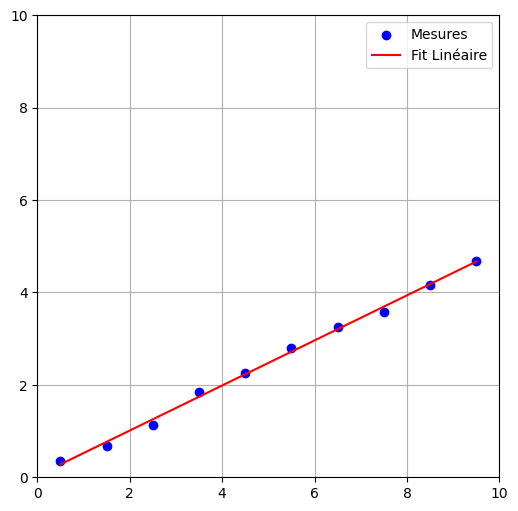

In [257]:
# --- Graphique ---
plt.figure(figsize=(6, 6)) # A square figure size helps with equal scaling
plt.style.use('default')

plt.scatter(x_vals, y_vals, color='blue', label='Mesures')
plt.plot(x_vals, y_model, color='red', label='Fit Linéaire')

# 1. Force the axis limits (Min, Max)
plt.xlim(0, 10)
plt.ylim(0, 10)

# 2. Force equal scaling (1 unit on x = 1 unit on y)
plt.gca().set_aspect('equal', adjustable='box')

plt.grid(True)
plt.legend()
plt.show()

In [258]:
# Force decimal precision for all dataframes
pd.options.display.float_format = '{:.4f}'.format

# Force decimal precision for NumPy printouts
np.set_printoptions(precision=4, suppress=True)

# Example: Displaying your FFT table neatly
data = {'k': [1000, 1250, 1300], 'abs(fft[k])': [17760, 7200, 21120]}
df = pd.DataFrame(data)
display(df)

,k,abs(fft[k])
0,1000,17760
1,1250,7200
2,1300,21120


## Symbolic Math Prettifier (SymPy)

In [259]:
sp.init_printing(use_latex='mathjax') # Makes symbols look professional

# Useful for your RMS work: Define standard symbols once
t, T, X_pk = sp.symbols('t T X_pk', positive=True)

# Function to quickly check RMS
def get_rms(signal_expr, period):
    rms_sq = sp.integrate(signal_expr**2, (t, 0, period)) / period
    return sp.simplify(sp.sqrt(rms_sq))

# Example usage:
v_sine = X_pk * sp.sin(2 * sp.pi * t / T)
display(get_rms(v_sine, T))

√2⋅Xₚₖ
──────
  2   

## Signal Analysis Helper (FFT Mapping)

In [260]:
def fft_info(fs, N):
    df = fs / N
    print(f"--- FFT Specs ---")
    print(f"Resolution (Δf): {df} Hz")
    print(f"Nyquist Limit:   {fs/2} Hz")
    return df

# Usage:
delta_f = fft_info(fs=48000, N=48000)
# Find frequency of index 1300
print(f"Freq at k=1300: {1300 * delta_f} Hz")

--- FFT Specs ---
Resolution (Δf): 1.0 Hz
Nyquist Limit:   24000.0 Hz
Freq at k=1300: 1300.0 Hz


# Exam code